# Import Packages and Construct Bitome

In [1]:
from pathlib import Path

import pandas as pd
from pymodulon.io import load_json_model
from pymodulon.plotting import *
import sys

sys.path.append('../../bitome2')

from bitome.core import Bitome

In [2]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

In [3]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

In [4]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

In [5]:
p1k = load_json_model('/Users/cam/Projects/precise1k/data/precise1k/precise1k.json.gz')

# Crp

In [6]:
crp1_df = p1k.view_imodulon('Crp-1')
crp2_df = p1k.view_imodulon('Crp-2')

crp_shared_genes = set(crp1_df.index).intersection(crp2_df.index)

crp1_df_unique = crp1_df.drop(index=crp_shared_genes)
crp1_df_unique = crp1_df_unique[(crp1_df_unique.regulator.notna()) &
                                (crp1_df_unique.regulator.str.contains('Crp'))]

crp2_df_unique = crp2_df.drop(index=crp_shared_genes)
crp2_df_unique = crp2_df_unique[(crp2_df_unique.regulator.notna()) &
                                (crp2_df_unique.regulator.str.contains('Crp'))]

crp_tfbs_df = mg1655.tfbs_table[mg1655.tfbs_table['tf'] == 'CRP'].drop_duplicates()
n_up, n_down = 150, 50

## Crp-1

### By genes

In [7]:
crp1_tfbs_dists = []
for crp1_gene_row in crp1_df_unique.itertuples():
    crp1_tus = mg1655._gene_to_tus[crp1_gene_row.Index]
    crp1_tu_df = mg1655.tu_table.loc[crp1_tus]

    for crp1_tu_row in crp1_tu_df.itertuples():
        if crp1_tu_row.strand == 1:
            area_l, area_r = crp1_tu_row.tss - n_up, crp1_tu_row.tss + n_down
        else:
            area_l, area_r = crp1_tu_row.tss - n_down, crp1_tu_row.tss + n_up
        tfbs_tu_df = crp_tfbs_df[
            ((crp_tfbs_df['left'] > area_l) & (crp_tfbs_df['left'] < area_r)) | 
            ((crp_tfbs_df['right'] > area_l) & (crp_tfbs_df['right'] < area_r))
        ].copy()
        tfbs_tu_df['center'] = tfbs_tu_df[['left', 'right']].mean(axis=1)
        for tfbs_row in tfbs_tu_df.itertuples():
            if crp1_tu_row.strand == 1:
                crp1_tfbs_dists.append(tfbs_row.center - crp1_tu_row.tss)
            else:
                crp1_tfbs_dists.append(crp1_tu_row.tss - tfbs_row.center)

## Crp-2

In [11]:
test = pd.read_csv('/Users/cam/Projects/precise1k/data/k12_modulome/bioproject_list_curated.csv')

In [8]:
crp2_tfbs_dists = []
for crp2_gene_row in crp2_df_unique.itertuples():
    crp2_tus = mg1655._gene_to_tus[crp2_gene_row.Index]
    crp2_tu_df = mg1655.tu_table.loc[crp2_tus]  

    for crp2_tu_row in crp2_tu_df.itertuples():
        if crp2_tu_row.strand == 1:
            area_l, area_r = crp2_tu_row.tss - n_up, crp2_tu_row.tss + n_down
        else:
            area_l, area_r = crp2_tu_row.tss - n_down, crp2_tu_row.tss + n_up
        tfbs_tu_df = crp_tfbs_df[
            ((crp_tfbs_df['left'] > area_l) & (crp_tfbs_df['left'] < area_r)) | 
            ((crp_tfbs_df['right'] > area_l) & (crp_tfbs_df['right'] < area_r))
        ].copy()
        tfbs_tu_df['center'] = tfbs_tu_df[['left', 'right']].mean(axis=1)
        for tfbs_row in tfbs_tu_df.itertuples():
            if crp2_tu_row.strand == 1:
                dist = tfbs_row.center - crp2_tu_row.tss
            else:
                dist = crp2_tu_row.tss - tfbs_row.center
            crp2_tfbs_dists.append(dist)

https://www.researchgate.net/figure/Transcription-activation-at-class-I-and-class-II-cyclic-AMP-receptor-protein_fig6_11091723

## Plot

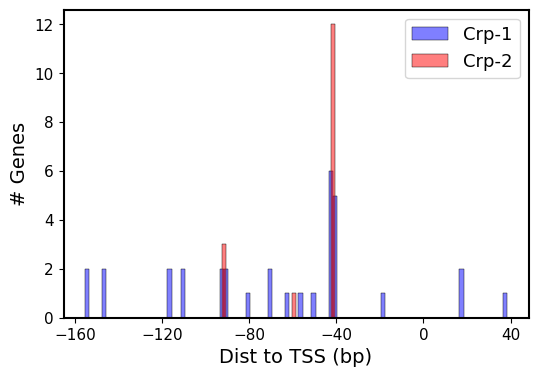

In [18]:
_, ax = plt.subplots(figsize=(6, 4))
sns.histplot(crp1_tfbs_dists, ax=ax, binwidth=2, label='Crp-1', color='blue', alpha=0.5)
sns.histplot(crp2_tfbs_dists, ax=ax, binwidth=2, label='Crp-2', color='red', alpha=0.5)
ax.set_xlabel('Dist to TSS (bp)', fontsize=14)
ax.set_ylabel('# Genes', fontsize=14)
ax.tick_params(axis='both', labelsize=11)
ax.legend(fontsize=13)
for s in ax.spines.values():
    s.set_linewidth(1.5)
ax.set_xticks(np.arange(-160, 50, 40));
plt.savefig('/Users/cam/Projects/precise1k/notebooks/precise1k/investigate_activities_figs/crp_sites.png', dpi=300)
plt.savefig('/Users/cam/Projects/precise1k/notebooks/precise1k/investigate_activities_figs/crp_sites.svg', dpi=300)

## Binding Kinetics

Data Taken from Mathematica notebook; just for plotting

In [184]:
kinetic_data = pd.read_csv('../data/crp_binding.csv', header=None)
kinetic_data.columns = ['x', 'y']
kinetic_data.head()

,x,y
0,0.991237,0.999647
1,0.990800,0.999629
2,0.990340,0.999610
3,0.989858,0.999590
4,0.989352,0.999570


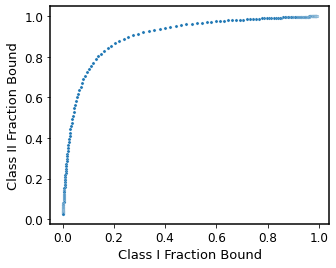

In [187]:
_, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(x='x', y='y', data=kinetic_data, s=10)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('Class I Fraction Bound', fontsize=13)
ax.set_ylabel('Class II Fraction Bound', fontsize=13)
for s in ax.spines.values():
    s.set_linewidth(1.5)
    
plt.savefig('/Users/cam/Projects/precise2/notebooks/fig5/kinetics.svg')

# Fur

In [35]:
fur1_df = precise2.view_imodulon('Fur-1')
fur2_df = precise2.view_imodulon('Fur-2')

fur_shared_genes = set(fur1_df.index).intersection(fur2_df.index)
fur_shared_genes

{'b0151',
 'b0152',
 'b0585',
 'b0588',
 'b0589',
 'b0591',
 'b0593',
 'b0595',
 'b0596',
 'b0597',
 'b1452',
 'b1705',
 'b4511'}

## Fur-1

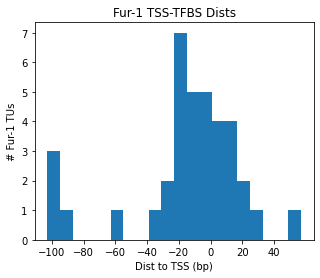

In [51]:
fur1_df_all = precise2.view_imodulon('Fur-1')
fur1_df = fur1_df_all.drop(index=fur_shared_genes)

# get unique TUs for genes in this iModulon that are regulated by CRP
fur1_tus = []
for fur1_row in fur1_df.itertuples():
    if pd.notna(fur1_row.regulator) and 'Fur' in fur1_row.regulator:
        fur1_tus += mg1655._gene_to_tus[fur1_row.Index]

fur1_tus = list(set(fur1_tus))
fur1_tu_df = mg1655.tu_table.loc[fur1_tus]

fur_tfbs_df = mg1655.tfbs_table[mg1655.tfbs_table['tf'] == 'Fur'].drop_duplicates()
n_up, n_down = 150, 50

tss_tfbs_dists = []
tsses = []
reg_types = []
for fur1_tu_row in fur1_tu_df.itertuples():
    tsses.append(fur1_tu_row.tss)
    if fur1_tu_row.strand == 1:
        area_l, area_r = fur1_tu_row.tss - n_up, fur1_tu_row.tss + n_down
    else:
        area_l, area_r = fur1_tu_row.tss - n_down, fur1_tu_row.tss + n_up
    tfbs_tu_df = fur_tfbs_df[
        ((fur_tfbs_df['left'] > area_l) & (fur_tfbs_df['left'] < area_r)) | 
        ((fur_tfbs_df['right'] > area_l) & (fur_tfbs_df['right'] < area_r))
    ].copy()
    tfbs_tu_df['center'] = tfbs_tu_df[['left', 'right']].mean(axis=1)
    for tfbs_row in tfbs_tu_df.itertuples():
        reg_types.append(tfbs_row.mode)
        if fur1_tu_row.strand == 1:
            tss_tfbs_dists.append(tfbs_row.center - fur1_tu_row.tss)
        else:
            tss_tfbs_dists.append(fur1_tu_row.tss - tfbs_row.center)
    

_, ax = plt.subplots(figsize=(5, 4))
ax.hist(tss_tfbs_dists, bins=20)
ax.set_title('Fur-1 TSS-TFBS Dists')
ax.set_xlabel('Dist to TSS (bp)')
ax.set_ylabel('# Fur-1 TUs')
ax.set_xticks(np.arange(-100, 60, 20));

## Fur-2

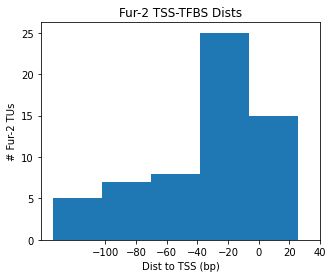

In [52]:
fur2_df_all = precise2.view_imodulon('Fur-2')
fur2_df = fur2_df_all.drop(index=fur_shared_genes)

# get unique TUs for genes in this iModulon that are regulated by CRP
fur2_tus = []
for fur2_row in fur2_df.itertuples():
    if pd.notna(fur2_row.regulator) and 'Fur' in fur2_row.regulator:
        fur2_tus += mg1655._gene_to_tus[fur2_row.Index]

fur2_tus = list(set(fur2_tus))
fur2_tu_df = mg1655.tu_table.loc[fur2_tus]

fur_tfbs_df = mg1655.tfbs_table[mg1655.tfbs_table['tf'] == 'Fur'].drop_duplicates()
n_up, n_down = 150, 50

tss_tfbs_dists2 = []
tsses = []
reg_types = []
for fur2_tu_row in fur2_tu_df.itertuples():
    tsses.append(fur2_tu_row.tss)
    if fur2_tu_row.strand == 1:
        area_l, area_r = fur2_tu_row.tss - n_up, fur2_tu_row.tss + n_down
    else:
        area_l, area_r = fur2_tu_row.tss - n_down, fur2_tu_row.tss + n_up
    tfbs_tu_df = fur_tfbs_df[
        ((fur_tfbs_df['left'] > area_l) & (fur_tfbs_df['left'] < area_r)) | 
        ((fur_tfbs_df['right'] > area_l) & (fur_tfbs_df['right'] < area_r))
    ].copy()
    tfbs_tu_df['center'] = tfbs_tu_df[['left', 'right']].mean(axis=1)
    for tfbs_row in tfbs_tu_df.itertuples():
        reg_types.append(tfbs_row.mode)
        if fur2_tu_row.strand == 1:
            tss_tfbs_dists2.append(tfbs_row.center - fur2_tu_row.tss)
        else:
            tss_tfbs_dists2.append(fur2_tu_row.tss - tfbs_row.center)
    

_, ax = plt.subplots(figsize=(5, 4))
ax.hist(tss_tfbs_dists2, bins=5)
ax.set_title('Fur-2 TSS-TFBS Dists')
ax.set_xlabel('Dist to TSS (bp)')
ax.set_ylabel('# Fur-2 TUs')
ax.set_xticks(np.arange(-100, 60, 20));